In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [38]:
df = pd.read_csv('training_data.csv')

# clean and keep only the data we want
data =[]
data = df[['id','stars','starVotes','length','ascent','descent', 'high', 'low', 
          'longitude','latitude', 'difficulty']]

In [39]:
mapping = {'green': 1, 'greenBlue': 2, 'blue': 3, 'blueBlack': 4, 'black': 5, 'dblack': 6}
data.replace(to_replace = {'difficulty' : mapping}, inplace = True)
data.describe()

/Users/iryna/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


,id,stars,starVotes,length,ascent,descent,high,low,longitude,latitude,difficulty
count,2.824000e+03,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000
mean,7.038744e+06,4.185942,7.789660,8.164837,1137.209986,-1065.430241,3837.538244,3031.027266,-97.885732,42.528836,3.281870
std,2.702557e+04,1.146773,19.438806,18.645545,2345.459481,2355.071712,3439.945213,2757.346092,15.356823,4.249339,1.351667
min,7.000000e+06,0.000000,0.000000,0.000000,0.000000,-54394.000000,0.000000,-280.000000,-121.591800,34.783200,1.000000
25%,7.016145e+06,4.000000,1.000000,1.800000,111.000000,-1105.500000,978.250000,779.750000,-111.617300,39.059575,3.000000
50%,7.035008e+06,4.500000,2.000000,4.000000,412.500000,-335.000000,2497.500000,1804.500000,-98.509300,42.551450,3.000000
75%,7.054825e+06,5.000000,6.000000,8.000000,1311.500000,-90.000000,6348.500000,5046.750000,-84.294600,45.566800,5.000000
max,7.093274e+06,5.000000,278.000000,308.300000,58094.000000,0.000000,14433.000000,12745.000000,-68.909700,53.954400,6.000000


In [198]:


data_final = data[data['starVotes'] > 3]
data_final = data_final[['length','ascent','descent', 'high', 'low', 
          'longitude','latitude', 'difficulty']]

X = data_final.loc[:, data_final.columns != 'difficulty']
y = data_final.loc[:, data_final.columns == 'difficulty']

# now, we need to split data into training and test sets
#labels = np.array(data_final.pop('label'))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [195]:
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

columns = X_train.columns
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_y = pd.DataFrame(data = os_data_y,columns = ['difficulty'])


In [166]:
# tune parameters for Random Forest model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(class_weight = 'balanced')
parameters = {'n_estimators'    : sp_randInt(100, 500),
                  'max_features'    : sp_randInt(1,5),
                  'min_samples_split' : sp_randInt(5, 30),
                  'max_depth'    : sp_randInt(4, 10)
                 }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(os_data_X, os_data_y)

/Users/iryna/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24887dd0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2486acd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2486a5d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2486ac90>})

In [167]:
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
print("\n The best score across ALL searched params:\n",
          randm.best_score_)
print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
print("\n ========================================================")


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=4,
                       min_samples_split=7, n_estimators=481)

 The best score across ALL searched params:
 0.6844961240310077

 The best parameters across ALL searched params:
 {'max_depth': 9, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 481}



In [191]:
clf = RandomForestClassifier(class_weight='balanced',max_depth=9, max_features=4,
                       min_samples_split=7, n_estimators=481)
RF_model = clf.fit(X_train, y_train)

/Users/iryna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [203]:
RF_model.score(X_test,y_test)


0.5448028673835126


In [179]:
y_predict = RF_model.predict(X_test)

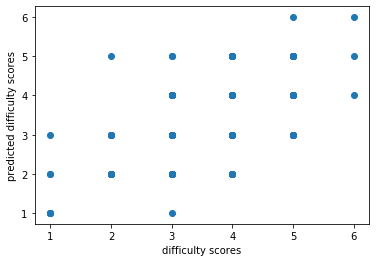

(279,)

In [180]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_predict)
plt.xlabel('difficulty scores')
plt.ylabel('predicted difficulty scores')
plt.savefig('prediction_scores_RF')
plt.show()
y_predict.shape

In [248]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': RF_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
1,ascent,0.326313
2,descent,0.213787
6,latitude,0.122833
0,length,0.108926
3,high,0.105860


In [200]:
# plot a ROC curve for each class

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6])
n_classes = y.shape[1]
n_samples, n_features = X.shape

print(n_classes)
print(n_samples)
print(n_features)


6
928
7


In [229]:
# Learn to predict each class against the other

from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

classifier = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',max_depth=9, max_features=4,
                       min_samples_split=7, n_estimators=481))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


In [231]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

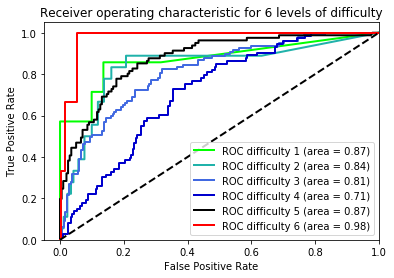

In [247]:
lw = 2
colors = ['lime', 'lightseagreen', 'royalblue', 'mediumblue', 'black', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC difficulty {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 6 levels of difficulty')
plt.legend(loc="lower right")
plt.savefig('ROC curve')
plt.show()